# **Deep Learning Assignment 2022**
**Unsupervised Domain Adaptation**

The purpose of the assignment is the one of building, training and evaluating a deep learning framework on a standard setting of Unsupervised Domain Adaptation. Namely we will dial with two datasets, so-called source and target domain. The chosen technique of domain adaptation has to mitigate the adverse effects of domain gap while training the model on the source distribution and testing it on the target distribution.

Let's start by importing the required libraries:

In [ ]:
!pip install -q keras
!pip install tensorflow

import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from os import makedirs
#from tqdm import tqdm
from google.colab import drive
from os import listdir
from os.path import join
from shutil import copytree
from __future__ import print_function, division
from sklearn.metrics import roc_curve, auc
import torch
import pandas as pd
from skimage import io, transform
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torchvision import datasets 
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

# ADDA
import argparse

#import torch
#from torch import nn
#from torch.utils.data import DataLoader

#from torchvision.datasets import MNIST

from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm, trange

#their functions
#import config
#from data import MNISTM (their function used on the dataset MNIST)
#from models import Net  
#from utils import loop_iterable, set_requires_grad, GrayscaleToRgb

from PIL import Image

from torch.autograd import Function

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Adaptiope Dataset**

Adaptiope dataset consists of images from 3 distinct sources, representing respectively synthetic, product, and real-world data. The original dataset includes 123 categories in each domain yet here we just select 20 categories from the product and real-world domains, such as backpack, bookcase, car jack, comb, crown, file cabinet, flat iron, game controller, glasses, helicopter, ice skates, letter tray, monitor, mug, network switch, over-ear headphones, pen, purse, stand mixer, and stroller.
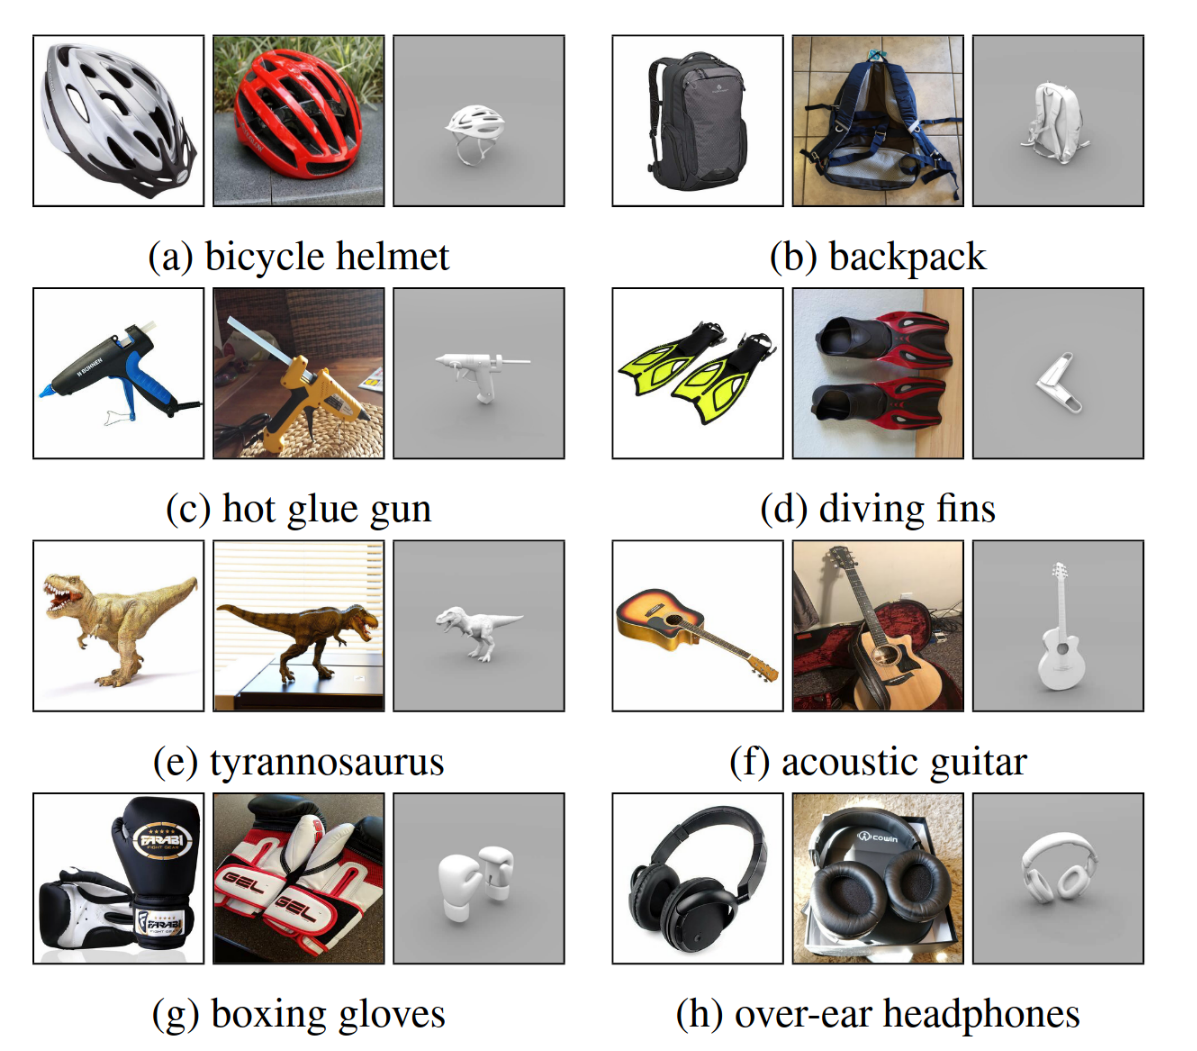

The following code allows us to deal with the Dataset, by preparing a smaller version of it. By reducing the number of classes in the dataset and copying only a subset of the original files, the resulting dataset is smaller and more manageable, while still retaining enough diversity to be useful for training a machine learning model.

In [ ]:
# Create a new directory called "dataset"
!mkdir dataset

# Copy the file "Adaptiope.zip" from the Google Drive folder "deep" to the "dataset" directory
!cp "/content/drive/MyDrive/deep/Adaptiope.zip" dataset/

# Unzip the "Adaptiope.zip" file in the "dataset" directory
!unzip dataset/Adaptiope.zip

# Remove any existing directory called "adaptiope_small"
!rm -rf adaptiope_small

# Create a new directory called "adaptiope_small"
!mkdir adaptiope_small

# Define a list of class names
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
           "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
           "purse", "stand mixer", "stroller"]

# Loop through the directories "Adaptiope/product_images" and "Adaptiope/real_life"
for d, td in zip(["Adaptiope/product_images", "Adaptiope/real_life"], ["adaptiope_small/product_images", "adaptiope_small/real_life"]):

    # Create a new directory in the "adaptiope_small" directory for each class
    makedirs(td)

    # Loop through each class
    for c in tqdm(classes):

        # Get the path to the current class directory
        c_path = join(d, c)

        # Get the target path for the current class directory in the "adaptiope_small" directory
        c_target = join(td, c)

        # Copy the contents of the current class directory to the corresponding directory in "adaptiope_small"
        copytree(c_path, c_target)

mkdir: cannot create directory ‘dataset’: File exists
Archive:  dataset/Adaptiope.zip
replace Adaptiope/product_images/watering can/watering can_080.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# **Datasets and Dataloaders**

To better deal with our data, we use Dataset and Dataloader classes.

The Dataset class serves as a representation includes all the necessary procedures to load a single batch item.

On the other hand, the DataLoader class is a convenient tool that enables us to load a batch of data from a dataset in an efficient manner.

In [ ]:
# Set the data directory paths
data_dir = "adaptiope_small"

# Specify the directory where the source images are saved
source_dir = os.path.join(data_dir, "product_images")

# Specify the directory where the target images are saved
target_dir = os.path.join(data_dir, "real_life")  

# apply a transformation on the images
transform = transforms.Compose([
    
    # resize the image to 224 x 224 pixels
    transforms.Resize((224, 224)),  

    # convert the image to a PyTorch tensor
    transforms.ToTensor()  
])

##______________________________________________________________________________
##____________________________________SOURCE____________________________________
##______________________________________________________________________________
# create the train/validation/test splits for the source domain
# create a dataset object for the source images
source_dataset = ImageFolder(source_dir, transform=transform)

##____________________________________SIZE____________________________________
# get the size of the source dataset
source_dataset_size = len(source_dataset)
# set the size of the training set to 80% of the dataset as required by the assignment
source_train_size = int(source_dataset_size * 0.8)
# set the size of the test set to the remaining 20%
source_test_size = source_dataset_size - source_train_size  

##____________________________________INDICES____________________________________
# generate random indices for the training set
source_train_indices = random.sample(range(source_dataset_size), source_train_size)
# generate the remaining indices for the test set
source_test_indices = list(set(range(source_dataset_size)) - set(source_train_indices))

##____________________________________SUBSETS____________________________________
# create a Subset object for the source training set
source_train_dataset = Subset(source_dataset, source_train_indices)
# create a Subset object for the source test set
source_test_dataset = Subset(source_dataset, source_test_indices)

##______________________________________________________________________________
##____________________________________TARGET____________________________________
##______________________________________________________________________________
# create the train/validation/test splits for the target domain
# create a dataset object for the target images
target_dataset = ImageFolder(target_dir, transform=transform)


##____________________________________SIZE____________________________________
# get the size of the target dataset
target_dataset_size = len(target_dataset)

# set the size of the training set to 80% of the dataset
target_train_size = int(target_dataset_size * 0.8)
# set the size of the test set to the remaining 20%
target_test_size = target_dataset_size - target_train_size

##____________________________________INDICES____________________________________
# generate random indices for the training set
target_train_indices = random.sample(range(target_dataset_size), target_train_size)
# generate the remaining indices for the test set
target_test_indices = list(set(range(target_dataset_size)) - set(target_train_indices))


##____________________________________SUBSETS____________________________________
# create a Subset object for the target training set
target_train_dataset = Subset(target_dataset, target_train_indices)
# create a Subset object for the target test set
target_test_dataset = Subset(target_dataset, target_test_indices)


##____________________________________DATA LOADERS____________________________________
# create the data loaders for each dataset
# create a data loader for the source training set
source_train_loader = DataLoader(source_train_dataset, batch_size=32, shuffle=True)

# create a data loader for the target training set
target_train_loader = DataLoader(target_train_dataset, batch_size=32, shuffle=True)

# create a data loader for the source test set
source_test_loader = DataLoader(source_test_dataset, batch_size=32, shuffle=False)

# create a data loader for the target test set
target_test_loader = DataLoader(target_test_dataset, batch_size=32, shuffle=False)

# **ResNet 18 Baseline**

As baseline we have decided to use ResNet 18, which is particularly suitable for object detection tasks.

ResNet18 is a convolutional neural network architecture part of the ResNet family of models, which was designed to overcome the problem of vanishing gradients in very deep neural networks. The vanishing gradient problem occurs when gradients become very small during backpropagation, making it difficult to train deep neural networks.

ResNet18 is made up of 18 layers, including several residual blocks. Residual blocks are a key feature of the ResNet architecture and are designed to enable the efficient training of very deep neural networks. In a residual block, the input to a layer is added to the output of the layer after passing through one or more convolutional layers. This so-called skip connection enables the network to learn residual functions, which can be easier to optimize than the original functions.

In [ ]:
class ResidualBlock(nn.Module):
    
    def __init__(self, inchannel, outchannel, stride=1):
    
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outchannel)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outchannel)

        # Shortcut connection to add to output
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):

        # First convolutional layer
        out = F.relu(self.bn1(self.conv1(x)))

        # Second convolutional layer
        out = self.bn2(self.conv2(out))

        # Shortcut connection
        out = out + self.shortcut(x)

        # ReLU activation
        out = F.relu(out)

        return out



class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes=20):
        super(ResNet, self).__init__()
    
        self.inchannel = 6
    
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=(5, 5), stride=1, padding=1, bias=False),  # define first convolution layer
            nn.BatchNorm2d(6),
            nn.ReLU()
        )

        # define the first residual block layer
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)  

        # define the second residual block layer
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)  

        # define the third residual block layer
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)  

        # define the fourth residual block layer
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)  

        # define the fully connected layer
        self.fc = nn.Linear(25088, num_classes)  
        
    def make_layer(self, block, channels, num_blocks, stride):
      
        strides = [stride] + [1] * (num_blocks - 1)
      
        layers = []
      
        for stride in strides:
      
            # create a residual block layer and append it to layers
            layers.append(block(self.inchannel, channels, stride))  
            self.inchannel = channels
      
        # create a sequential layer using the created residual blocks
        return nn.Sequential(*layers)  
    
    def forward(self, x):
      
        # pass the input through the first convolution layer
        out = self.conv1(x)  
      
        # pass the input through the first residual block layer
        out = self.layer1(out) 
      
        # pass the input through the second residual block layer
        out = self.layer2(out)  
      
        # pass the input through the third residual block layer
        out = self.layer3(out)  
      
        # pass the input through the fourth residual block layer
        out = self.layer4(out)  
      
        # perform average pooling on the output of the last residual block layer
        out = F.avg_pool2d(out, 4) 
      
        # reshape the output tensor 
        out = out.view(out.size(0), -1)  
      
        # flatten the output tensor
        out = nn.Flatten()(out)  
      
        # pass the output tensor through the fully connected layer
        out = self.fc(out)  
        return out

In [ ]:
def ResNet18():
    return ResNet(ResidualBlock)

Here we instantiate the model and we define the optimizer and the loss we are going to use. Namely as optimizer SGD has been selected and as criterion the Cross Entropy Loss.

In [ ]:
# Set the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set some parameters
epoch = 1
batch_size = 128
learning_rate = 0.01

# Instantiate ResNet18
net = ResNet18().to(device)

# Loss funtion
cost_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# **Training Step**

In [ ]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to training mode
  net.train() 

  # iterate over the training set
  for batch_idx, (inputs, targets) in enumerate(data_loader):

    # load data into GPU
    inputs = inputs.to(device)
    targets = targets.to(device)
      
    # forward pass
    outputs = net(inputs)

    # loss computation
    loss = cost_function(outputs,targets)

    # backward pass
    loss.backward()
    
    # parameters update
    optimizer.step()
    
    # gradients reset
    optimizer.zero_grad()

    # fetch prediction and loss value
    samples += inputs.shape[0]
    cumulative_loss += loss.item()
    _, predicted = outputs.max(dim=1) # max() returns (maximum_value, index_of_maximum_value)

    # compute training accuracy
    cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

# **Testing Step**

In [ ]:
def test_step(net, data_loader, cost_function, device='cuda'):

  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  # set the network to evaluation mode
  net.eval() 

  # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
  with torch.no_grad():

    # iterate over the test set
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      
      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)
        
      # forward pass
      outputs = net(inputs)

      # loss computation
      loss = cost_function(outputs, targets)

      # fetch prediction and loss value
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      _, predicted = outputs.max(1)

      # compute accuracy
      cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples, cumulative_accuracy/samples*100

In [ ]:
def main(batch_size, 
         device, 
         learning_rate, 
         weight_decay, 
         momentum, 
         epochs,
         train_loader,
         test_loader,
         optimizer,
         cost_function):


    # run a single test step beforehand and print metrics
    print('Before training:')
    train_loss, train_accuracy = test_step(net, train_loader, cost_function)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

    # iterate over the number of epochs
    for e in range(epochs):

      # train & log
      train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function)
      print('Epoch: {:d}'.format(e+1))
      print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
      print('-----------------------------------------------------')

    # compute and print final metrics
    print('After training:')
    train_loss, train_accuracy = test_step(net, train_loader, cost_function)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function)

    print('\t Training loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\t Test loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

This function receives as input the network, a set of input data represented as a data_loader, and a specific device on which to perform the prediction. The function then performs an evaluation of the model using the input data.

Finally, the function returns the two arrays y_pred and y_true containing the model predictions and labels corresponding to the input data.

In [ ]:
def predict(net, data_loader, device='cuda'):
    
    # set the network to evaluation mode
    net.eval()
    
    # initialize empty lists to store predicted and true labels
    y_pred = []
    y_true = []

    # disable gradient computation (we are only predicting, we do not want our model to be modified in this step!)
    with torch.no_grad():
    
        # iterate over the data loader
        for batch_idx, (inputs, targets) in enumerate(data_loader):
    
            # load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            outputs = net(inputs)
            # retrieve the predicted class labels
            _, predicted = outputs.max(dim=1)

            # append predicted and true labels to their corresponding lists
            y_pred += predicted.cpu().numpy().tolist()
            y_true += targets.cpu().numpy().tolist()
            
    # return the predicted and true labels as lists
    return y_pred, y_true

#**Evaluation**

## **Confusion Matrix**

The confusion matrix is a tool for evaluating the performance of a classification model. It displays the number of true positives (TP), false positives (FP), false negatives (FN) and true negatives (TN) obtained by the model on a set of test data.

In [ ]:
def confusion_matrix(y_true, y_pred, num_classes):
    conf_mat = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        true_class = int(y_true[i])
        pred_class = int(y_pred[i])
        conf_mat[true_class, pred_class] += 1

    return conf_mat

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    num_classes=len(classes)
    conf_mat = confusion_matrix(y_true, y_pred, num_classes)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues', square=True, cbar=False, ax=ax)
    
    # Set labels and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes, rotation=0)
    
    plt.show()

## **Roc Curve**

The ROC curve (Receiver Operating Characteristic curve) is a graph that is used to evaluate the performance of a binary classification model. The curve is plotted by representing the rate of true positives (True Positive Rate) versus the rate of false positives (False Positive Rate).

To obtain the ROC curve, the model is evaluated on a set of test data, and the True Positive Rate and False Positive Rate are calculated for each possible classification threshold (threshold). The ROC curve is then a graphical representation of the rates of true positives and false positives as the classification threshold changes.

Specifically, the area under the ROC curve (AUC, Area Under the Curve) is a performance index that measures the model's ability to distinguish between positive and negative classes, regardless of the choice of classification threshold. A model that has an area under the ROC curve of 0.5 is equivalent to a model that makes predictions randomly, while a model that has an area under the ROC curve of 1.0 is able to distinguish perfectly between positive and negative classes.

In [ ]:
def plot_roc_curve(net, data_loader, num_classes=20, device='cuda'):
    net.eval()
    plt.figure(figsize=(17, 12))
    
    for class_idx in range(num_classes):
        y_score = []
        y_true = []

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = net(inputs)
                class_outputs = outputs[:, class_idx]
                _, predicted = outputs.max(dim=1)

                y_score += class_outputs.cpu().numpy().tolist()
                y_true += (targets == class_idx).cpu().numpy().tolist()

        fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='ROC curve for class {} (area = {:0.2f})'.format(class_idx, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## **Predicted labels**

The predicted labels method refers to the prediction of class labels for a set of test data. The model attempts to learn a function that maps input features to corresponding class outputs. When a test data set is presented, the model uses this function to predict the class label associated with each data point. This prediction is called a predicted label or predicted label. The accuracy of the model's predictions can be evaluated by comparing the predictions with the actual class labels in the test data set.

In [ ]:
def plot_predicted_labels(net, data_loader, device='cuda'):
    # Set the network to evaluation mode
    net.eval()

    # Create an empty list to hold the predicted labels
    predicted_labels = []

    # Get class names from the data loader
    classes = data_loader.dataset.classes if isinstance(data_loader.dataset, ImageFolder) else source_dataset.classes

    # Iterate over the data in the test_loader
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Move the data to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Compute the outputs of the model
        outputs = net(inputs)

        # Get the predicted labels for this batch
        _, predicted = torch.max(outputs.data, 1)

        # Convert tensor to list and append to predicted_labels
        predicted_labels += predicted.cpu().numpy().tolist()

    # Create a Counter object from the predicted labels list
    predicted_labels_count = Counter(predicted_labels)

    # Create a list of the counts for each class
    counts = [predicted_labels_count[i] for i in range(len(classes))]

    # Plot the bar chart
    plt.figure(figsize=(10,5))
    plt.bar(classes, counts)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Predicted Labels')
    plt.show()

# **Training the baseline**

## **Source $⟶$ Source**

In [ ]:
main(128, 'cuda:0', 0.01, 0.000001, 0.9, 1, source_train_loader, source_test_loader, optimizer, cost_function)

Before training:
	 Training loss 0.09364, Training accuracy 4.06
	 Test loss 0.09735, Test accuracy 4.50
-----------------------------------------------------
Epoch: 1
	 Training loss 0.91019, Training accuracy 6.56
-----------------------------------------------------
After training:
	 Training loss 27.81004, Training accuracy 9.44
	 Test loss 36.95894, Test accuracy 7.00
-----------------------------------------------------


In [ ]:
y_true, y_pred = predict(net, source_test_loader, device='cuda')

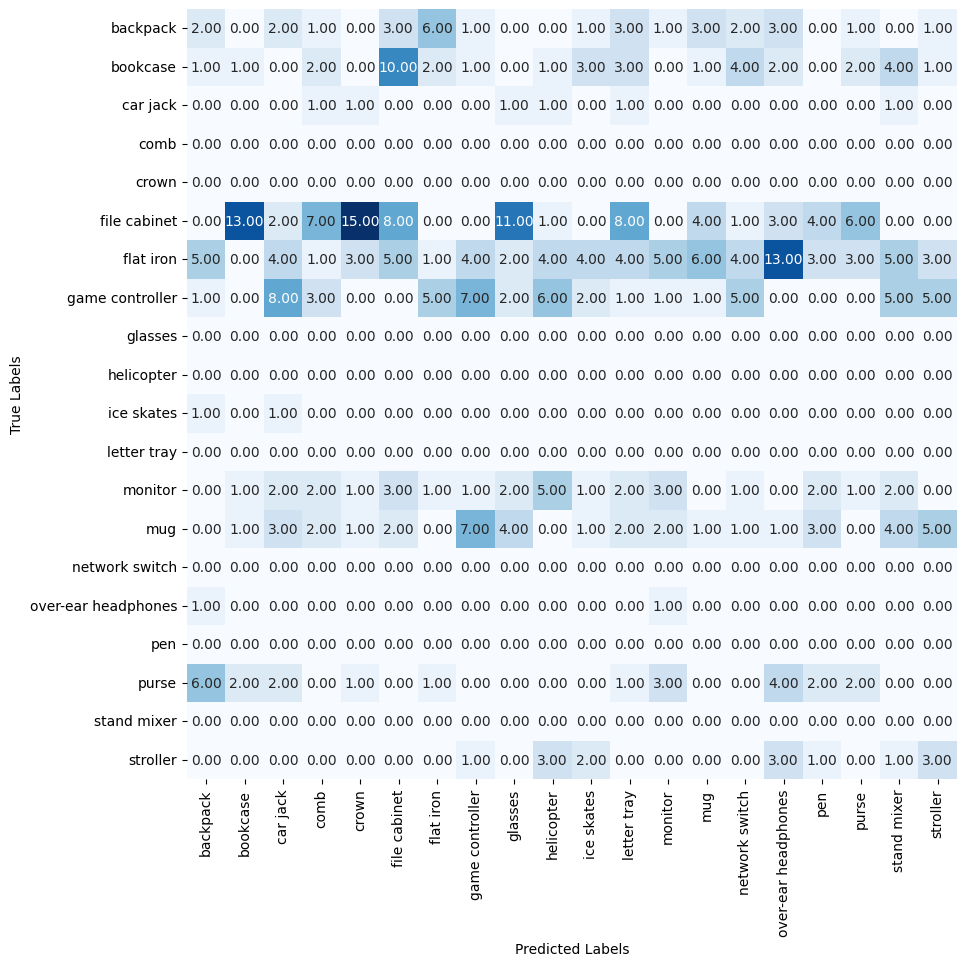

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

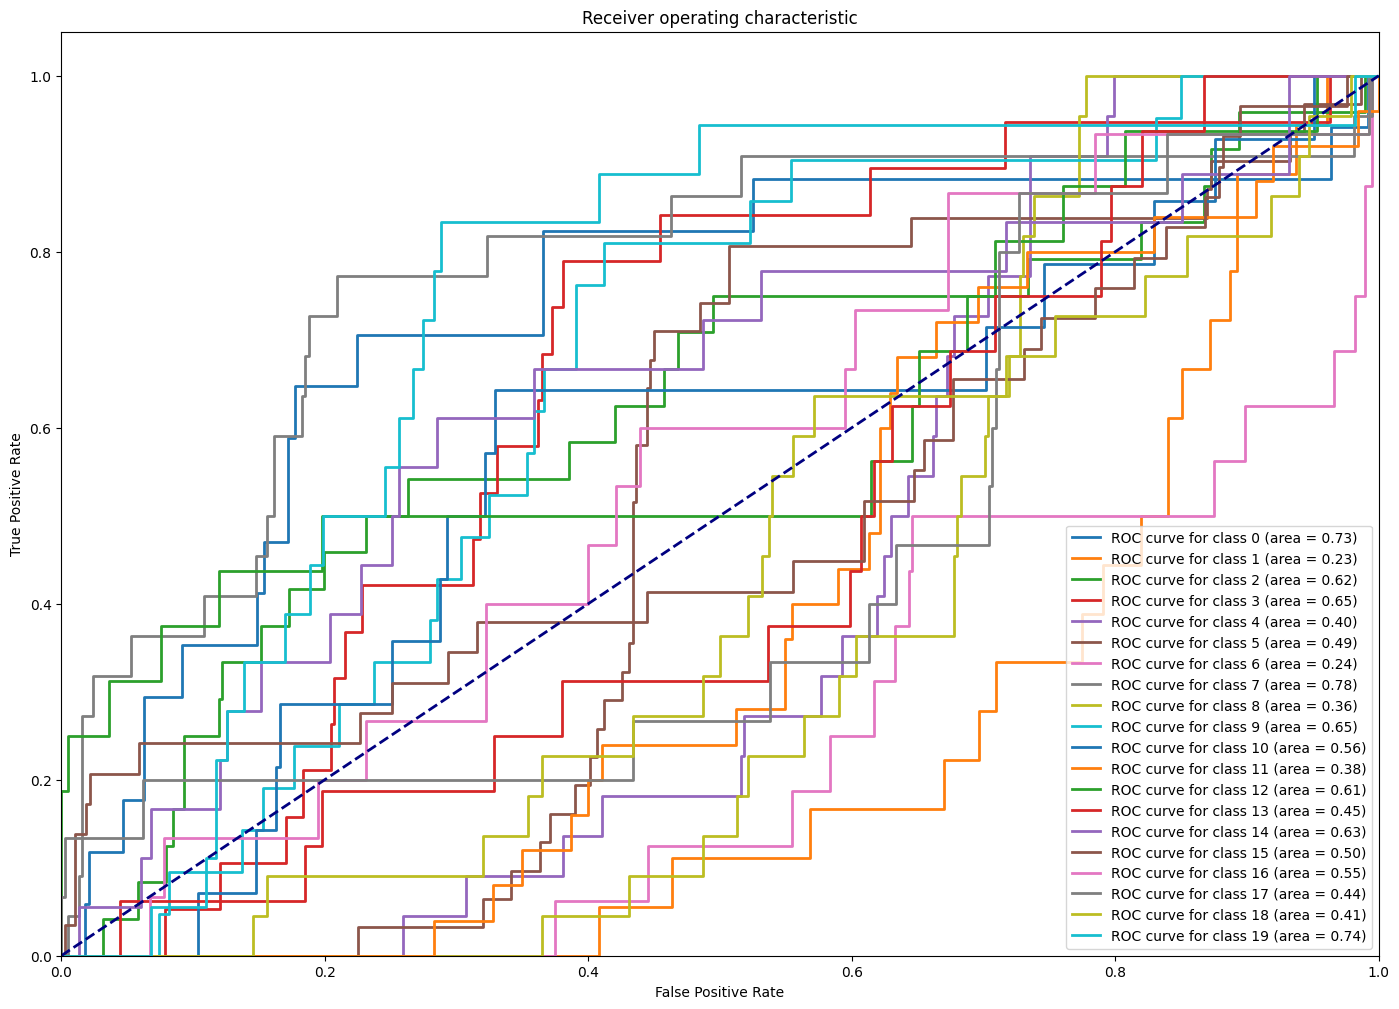

In [ ]:
plot_roc_curve(net, source_test_loader)

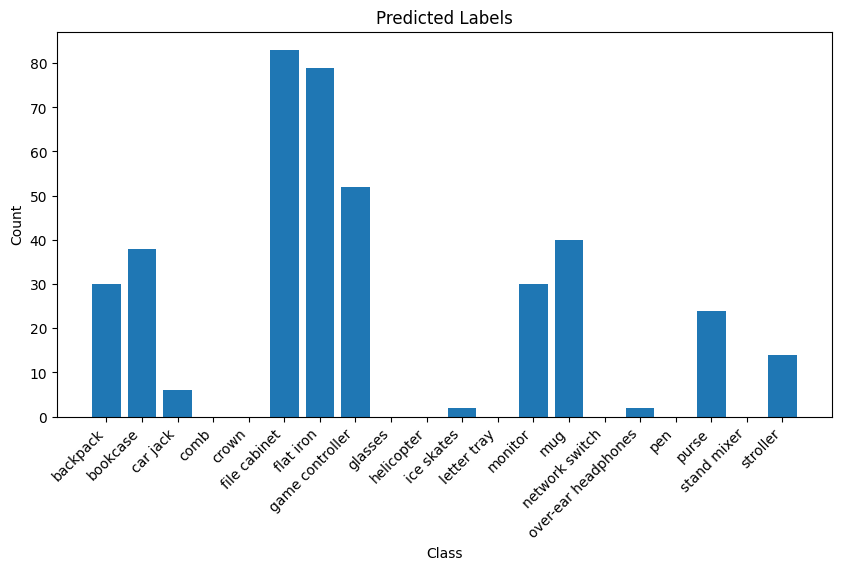

In [ ]:
plot_predicted_labels(net, source_test_loader)

In [ ]:
train_loss, train_acc = training_step(net, source_train_loader, optimizer, cost_function, device='cuda')
test_loss, test_acc = test_step(net, source_test_loader, cost_function, device='cuda')

In [ ]:
print(test_loss)

0.10974136888980865


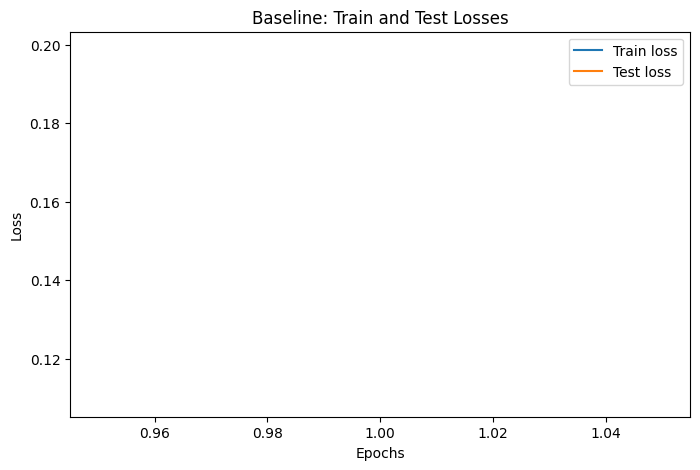

In [ ]:
# Plot train and test losses
plt.figure(num=1, figsize=(8, 5)).patch.set_facecolor('white')
plt.title('Baseline: Train and Test Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(1, train_loss, label='Train loss')
plt.plot(1, test_loss, label='Test loss')
plt.legend()
plt.show()

## **Source $⟶$ Target**

In [ ]:
main(128, 'cuda:0', 0.01, 0.000001, 0.9, 1, source_train_loader, target_test_loader, optimizer, cost_function)

Before training:
	 Training loss 0.09561, Training accuracy 8.25
	 Test loss 0.13463, Test accuracy 5.00
-----------------------------------------------------
Epoch: 1
	 Training loss 0.08802, Training accuracy 17.81
-----------------------------------------------------
After training:
	 Training loss 0.07748, Training accuracy 26.69
	 Test loss 0.13752, Test accuracy 5.75
-----------------------------------------------------


In [ ]:
y_true, y_pred = predict(net, target_test_loader, device='cuda')

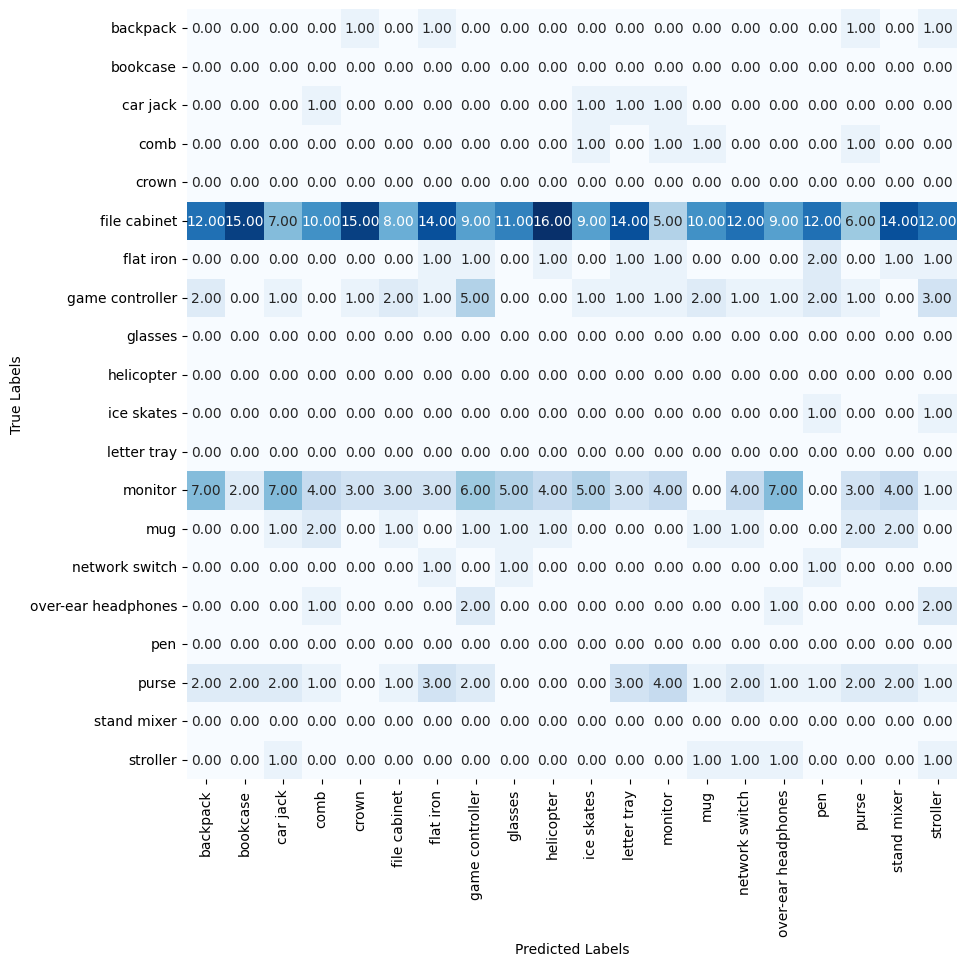

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

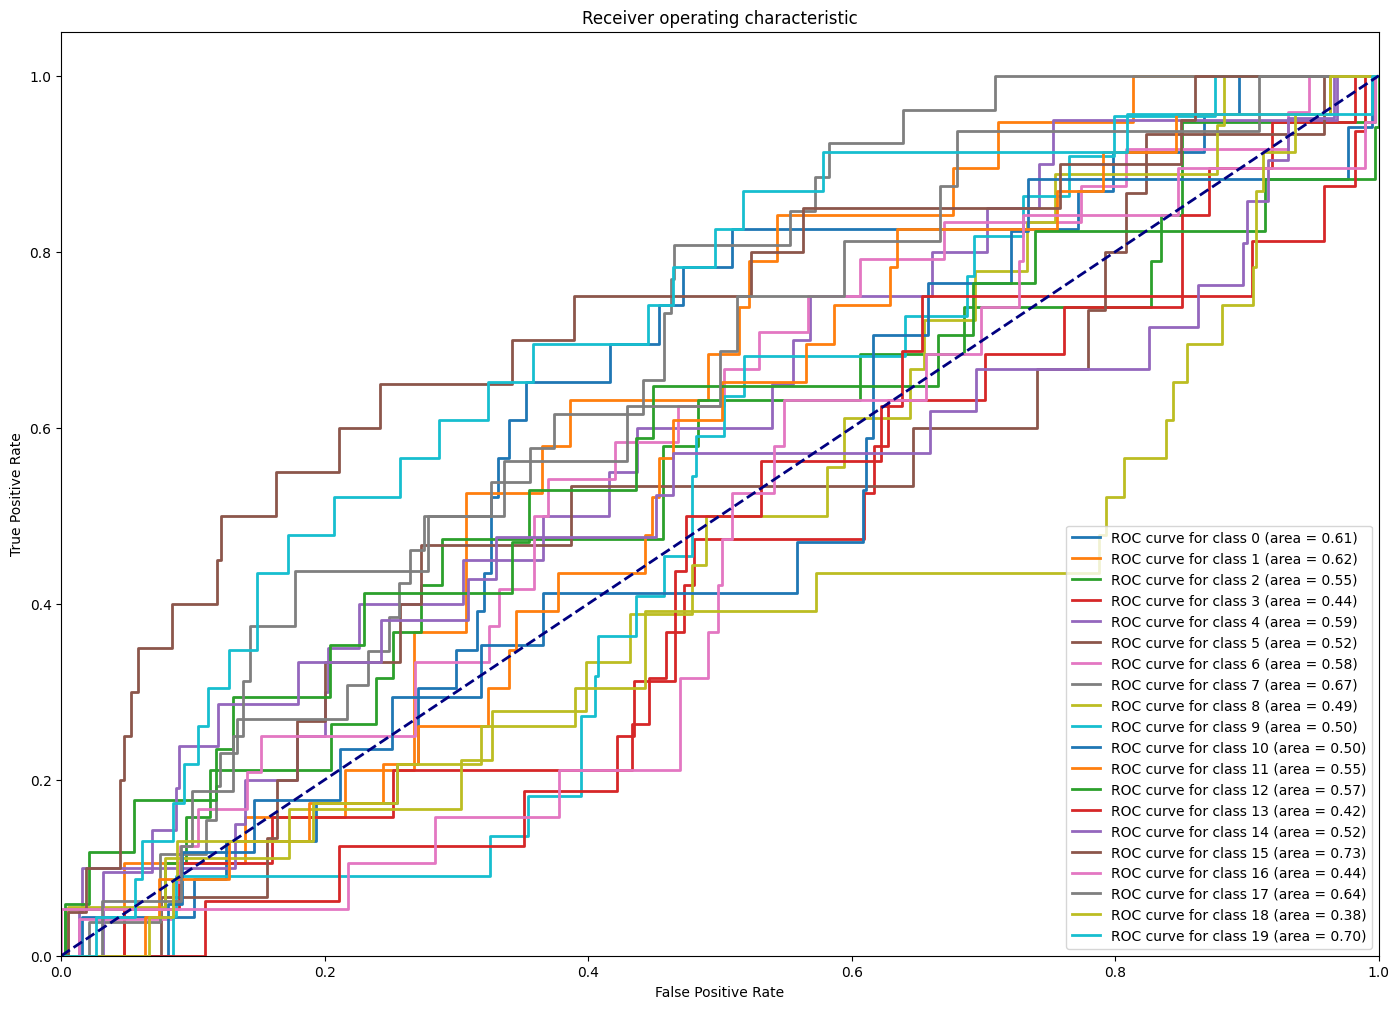

In [ ]:
plot_roc_curve(net, target_test_loader)

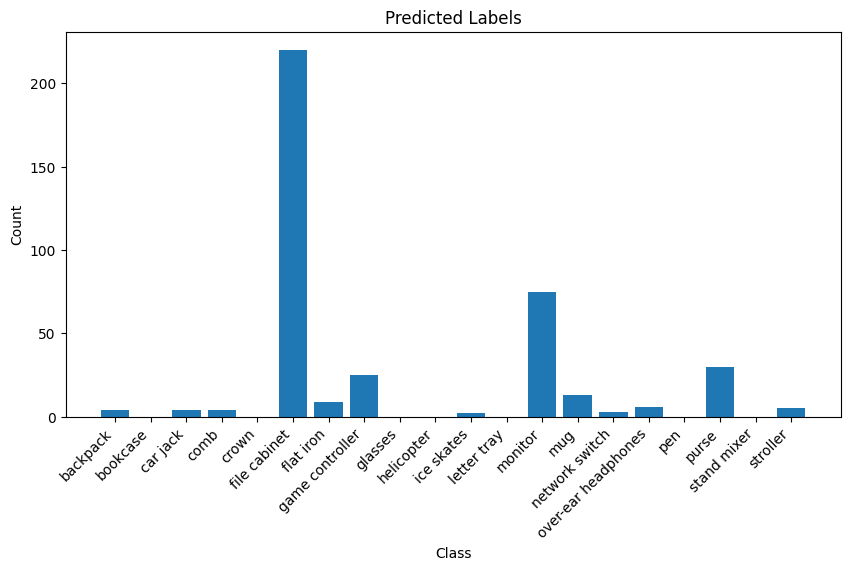

In [ ]:
plot_predicted_labels(net, target_test_loader)

## **Target $⟶$ Source**

In [ ]:
main(128, 'cuda:0', 0.01, 0.000001, 0.9, 10, target_train_loader, source_test_loader, optimizer, cost_function)

In [ ]:
y_true, y_pred = predict(net, source_test_loader, device='cuda')

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

In [ ]:
plot_roc_curve(net, source_test_loader)

In [ ]:
plot_predicted_labels(net, source_test_loader)

## **Target $⟶$ Target**

In [ ]:
main(128, 'cuda:0', 0.01, 0.000001, 0.9, 10, target_train_loader, target_test_loader, optimizer, cost_function)

In [ ]:
y_true, y_pred = predict(net, target_test_loader, device='cuda')

In [ ]:
plot_confusion_matrix(y_true, y_pred, classes)

In [ ]:
plot_roc_curve(net, target_test_loader)

In [ ]:
plot_predicted_labels(net, target_test_loader)

Adversarial Discriminative Domain Adaptation (ADDA)

https://github.com/jvanvugt/pytorch-domain-adaptation/blob/master/adda.py


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.Dropout2d(),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

Utility functions

In [ ]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad


def loop_iterable(iterable):
    while True:
        yield from iterable


class GrayscaleToRgb:
    """Convert a grayscale image to rgb"""
    def __call__(self, image):
        image = np.array(image)
        image = np.dstack([image, image, image])
        return Image.fromarray(image)

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #already done

def main2(MODEL_FILE, batch_size, iterations, epochs, k_disc, k_clf): 
    source_model = Net().to(device)
    source_model.load_state_dict(torch.load(MODEL_FILE)) #our model here
    source_model.eval()
    set_requires_grad(source_model, requires_grad=False)
    
    clf = source_model
    source_model = source_model.feature_extractor

    target_model = Net().to(device)
    target_model.load_state_dict(torch.load(MODEL_FILE)) #our model here
    target_model = target_model.feature_extractor

    discriminator = nn.Sequential(
        nn.Linear(320, 50),
        nn.ReLU(),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.Linear(20, 1)
    ).to(device)

    half_batch = batch_size // 2
    #source_dataset = MNIST(config.DATA_DIR/'mnist', train=True, download=True, transform=Compose([GrayscaleToRgb(), ToTensor()]))
    source_loader = DataLoader(source_dataset, batch_size=half_batch,
                               shuffle=True, num_workers=1, pin_memory=True)
    
    #target_dataset = MNISTM(train=False)
    target_loader = DataLoader(target_dataset, batch_size=half_batch, shuffle=True, num_workers=1, pin_memory=True)

    discriminator_optim = torch.optim.Adam(discriminator.parameters())
    target_optim = torch.optim.Adam(target_model.parameters())
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(1, epochs+1):
        batch_iterator = zip(loop_iterable(source_loader), loop_iterable(target_loader))

        total_loss = 0
        total_accuracy = 0
        for _ in trange(iterations, leave=False):
            # Train discriminator
            set_requires_grad(target_model, requires_grad=False)
            set_requires_grad(discriminator, requires_grad=True)
            for _ in range(k_disc):
                (source_x, _), (target_x, _) = next(batch_iterator)
                source_x, target_x = source_x.to(device), target_x.to(device)

                source_features = source_model(source_x).view(source_x.shape[0], -1)
                target_features = target_model(target_x).view(target_x.shape[0], -1)

                discriminator_x = torch.cat([source_features, target_features])
                discriminator_y = torch.cat([torch.ones(source_x.shape[0], device=device),
                                             torch.zeros(target_x.shape[0], device=device)])

                preds = discriminator(discriminator_x).squeeze()
                loss = criterion(preds, discriminator_y)

                discriminator_optim.zero_grad()
                loss.backward()
                discriminator_optim.step()

                total_loss += loss.item()
                total_accuracy += ((preds > 0).long() == discriminator_y.long()).float().mean().item()

            # Train classifier
            set_requires_grad(target_model, requires_grad=True)
            set_requires_grad(discriminator, requires_grad=False)
            for _ in range(k_clf):
                _, (target_x, _) = next(batch_iterator)
                target_x = target_x.to(device)
                target_features = target_model(target_x).view(target_x.shape[0], -1)

                # flipped labels
                discriminator_y = torch.ones(target_x.shape[0], device=device)

                preds = discriminator(target_features).squeeze()
                loss = criterion(preds, discriminator_y)

                target_optim.zero_grad()
                loss.backward()
                target_optim.step()

        mean_loss = total_loss / (iterations*k_disc)
        mean_accuracy = total_accuracy / (iterations*k_disc)
        tqdm.write(f'EPOCH {epoch:03d}: discriminator_loss={mean_loss:.4f}, '
                   f'discriminator_accuracy={mean_accuracy:.4f}')

        # Create the full target model and save it
        clf.feature_extractor = target_model
        torch.save(clf.state_dict(), 'trained_models/adda.pt')


#if __name__ == '__main__':
#    arg_parser = argparse.ArgumentParser(description='Domain adaptation using ADDA')
#    arg_parser.add_argument('MODEL_FILE', help='A model in trained_models')
#    arg_parser.add_argument('--batch-size', type=int, default=64)
#    arg_parser.add_argument('--iterations', type=int, default=500)
#    arg_parser.add_argument('--epochs', type=int, default=5)
#    arg_parser.add_argument('--k-disc', type=int, default=1)
#    arg_parser.add_argument('--k-clf', type=int, default=10)
#    args = arg_parser.parse_args()
#    main(args)

#(MODEL_FILE, batch_size, iterations, epochs, k_disk, k_clf)

In [ ]:
main2("ResNet", 128, 500, 3, 1, 10)

AttributeError: ignored